In [ ]:
## This is a series of examples demonstrating the use of the icanswim/cosmosis repo 
## for data science and machine learning projects.
## This repo is intended to be used as the boiler plate for data science and machine learning projects.
## See the icanswim/qchem repo for a demonstration of the use of this (icanswim/cosmosis) repo.

In [1]:
from model import FFNet, tv_model, IdentityModel, GPT
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS, ExampleDataset
from dataset import ImageDatasetStats, AsTensor, SqueezeN, DType, Pad1d, EmbedLookup, Reshape

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

import numpy as np

In [ ]:
#Cosmosis blank parameters

lookup_feature_3 = ExampleDataset.embed_lookup['feature_3']
ds_param = {'train_param': {'input_dict': {'X': ['feature_1','feature_2'],
                                           'feature_3': ['feature_3']},
                            'transforms': {'feature_1': [ExampleTransform(10), AsTensor()],
                                           'feature_2': [Reshape(-1), AsTensor()],
                                           'feature_3': [Pad1d(5), EmbedLookup(lookup_feature_3), AsTensor()]},
                            'boom': 'bang'}}

model_param = {'some_param': 128,
               'X': None,
               'y': 'y',
               'embed_param': {'feature_3': (voc,vec,padding_idx,trainable),
                               'some_param': True,
                               'flatten': True}} 
                                       
metrics_param = {'report_interval': 10,
                  'log_plot': True,
                  'min_lr': .005} #break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .5, 
                'patience': 2,
                'cooldown': 2}

learn = Learn([DS], 
              Model,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Optimizer, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=LossFunction,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=12, epochs=1, gpu=True)

In [2]:
#example cosmosis dataset (CDataset)

class ExampleTransform():
    def __init__(self, num):
        self.num = num
        
    def __call__(self, arr):
        return np.add(arr, self.num)


class ExampleDataset(CDataset):
    #zero is the lookup for the padding index 
    embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                    'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0},
                    'feature_6': {'e': 1, 'f': 2, 'g': 3, '0': 0}}
    
    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([[.02,.03],[.04,.05]]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1]),
                       'feature_6': np.asarray(['e','f','g'])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([[.1,.2],[.3,.4]]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2]),
                       'feature_6': np.asarray(['f','f','g'])}}
        
        print(boom)
        return datadic
    
lookup_feature_3 = ExampleDataset.embed_lookup['feature_3']
lookup_feature_4 = ExampleDataset.embed_lookup['feature_4']
lookup_feature_6 = ExampleDataset.embed_lookup['feature_6']
ds_param = {'train_param': {'input_dict': {
                                           'X2': ['feature_1','feature_2'], 
                                           'X3': ['feature_2'],
                                           'embed_3': ['feature_3'],
                                           'embed_4': ['feature_4'],
                                           'target': ['feature_5'],
                                            },
                            'transforms': {'feature_1': [ExampleTransform(10), AsTensor()],
                                           'feature_2': [Reshape(-1), AsTensor()],
                                           'feature_3': [Pad1d(5), EmbedLookup(lookup_feature_3), AsTensor()],
                                           'feature_4': [Pad1d(5), EmbedLookup(lookup_feature_4), AsTensor()],
                                           'feature_5': [AsTensor()],
                                           'feature_6': [Pad1d(5), EmbedLookup(lookup_feature_6), AsTensor()]},
                            'boom': 'bang'}}
    
ed = ExampleDataset(**ds_param['train_param'])
print('ed[1]: ', ed[1])

model_param = {'device': 'cpu',
               'X': ['X2', 'X3'],
               'y': ['target'],
               'embed_param': {'embed_3': (4,8,0,False),
                               'embed_4': (5,8,0,False),
                               'flatten': True}}

im = IdentityModel(model_param)
print(im)
print('embedding_layer: ', im.embedding_layer)

out = im(ed[1])
print('out: ', out)
print('out.shape: ', out.shape) # (1+4+4+5*8+5*8) = 89

bang
CDataset created...
ed[1]:  {'X2': tensor([10.0400,  0.0200,  0.0300,  0.0400,  0.0500], dtype=torch.float64), 'X3': tensor([0.0200, 0.0300, 0.0400, 0.0500], dtype=torch.float64), 'embed_3': tensor([1, 0, 0, 0, 0]), 'embed_4': tensor([3, 3, 4, 0, 0]), 'target': tensor([1.1000], dtype=torch.float64)}
CModel loaded...
IdentityModel(
  (layers): ModuleList(
    (0): Identity()
  )
)
embedding_layer:  {'embed_3': Embedding(4, 8, padding_idx=0), 'embed_4': Embedding(5, 8, padding_idx=0)}
out:  tensor([10.0400,  0.0200,  0.0300,  0.0400,  0.0500,  0.0200,  0.0300,  0.0400,
         0.0500,  1.1000,  0.4941, -0.9236, -0.8331, -2.3411,  1.3874,  2.4729,
        -0.5379,  0.4473,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0

In [2]:
#example showing transformer inputs, outputs and parameters

class ExampleTransform():
    def __init__(self, num):
        self.num = num
        
    def __call__(self, arr):
        return np.add(arr, self.num)


lookup_feature_3 = ExampleDataset.embed_lookup['feature_3']
lookup_feature_4 = ExampleDataset.embed_lookup['feature_4']
lookup_feature_6 = ExampleDataset.embed_lookup['feature_6']
ds_param = {'train_param': {'input_dict': {'X1': ['feature_3'],
                                           'X2': ['feature_4'],
                                           'y': ['feature_5']},
                            'transforms': {'feature_1': [ExampleTransform(10), AsTensor()],
                                           'feature_2': [Reshape(-1), AsTensor()],
                                           'feature_3': [Pad1d(12), EmbedLookup(lookup_feature_3), AsTensor()],
                                           'feature_4': [Pad1d(12), EmbedLookup(lookup_feature_4), AsTensor()],
                                           'feature_5': [AsTensor()],
                                           'feature_6': [EmbedLookup(lookup_feature_6), AsTensor()]},
                              'boom': 'bang'}}
    
ed = ExampleDataset(**ds_param['train_param'])
print('ed[1]: ', ed[1])

model_param = {'device': 'cpu',
               'd_model': 16, # matches embedding dimension
               'nhead': 4, 
               'num_layers': 2,
               'embed_param': {'X1': (4,16,0,True), # embed key matches input_dict key ('X1')
                               'X2': (5,16,0,True)}} # vector dimension matches d_model dimension
                                 
gpt = GPT(model_param)
print(gpt)
print('embedding_layer: ', gpt.embedding_layer)
out = gpt(ed[1])
print('out: ', out)
print('out.shape: ', out.shape) # (feature_length, embedding_lenth) = (12, 16)

bang
CDataset created...
ed[1]:  {'X1': tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'X2': tensor([3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'y': tensor([1.1000], dtype=torch.float64)}
CModel loaded...
GPT(
  (layers): ModuleList(
    (0): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (no

In [4]:
#example cosmosis sklearn regression dataset wrapper (SKDS)
                            
ds_param = {'train_param': {'input_dict': {'model_input': ['X'],
                                           'y': ['y']},
                            'dataset': 'make_regression',
                            'sk_param': {'n_samples': 100,
                                         'n_features': 5},
                            'features_dtype': 'float32',
                            'targets_dtype': 'float32'}}

sk = SKDS(**ds_param['train_param'])

sk[1]

creating scikit learn make_regression dataset...
CDataset created...


{'model_input': array([-1.6819882 ,  0.08517368, -1.4711541 , -0.27413824,  0.6487189 ],
       dtype=float32),
 'y': array([-106.94283], dtype=float32)}

In [5]:
#example cosmosis sklearn classification dataset wrapper (SKDS)
ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'int64',
                            'transforms': {'y': [AsTensor()],
                                           'X': [AsTensor()]},
                            'dataset': 'make_classification',
                            'sk_param': {'n_samples': 1000,
                                         'n_features': 30,
                                         'n_informative': 20,
                                         'n_clusters_per_class': 3,
                                         'flip_y': 0.05,
                                         'class_sep': 0.1,
                                         'n_classes': 4}}}

sk = SKDS(**ds_param['train_param'])

print(sk[1])


creating scikit learn make_classification dataset...
CDataset created...
{'X': tensor([ -6.1927,   0.6378,   2.0045,  -2.1506,  -1.8044,   5.4520,  -0.8183,
         -1.6978,  -4.9253,  -2.3235,  -5.0413,   4.1372,  -2.0409,  -0.1313,
         -1.6283,   1.5412,  -1.4866,   1.6343, -11.6799,   2.1071,  -1.5194,
          1.7269,   0.3337,   1.1222,  -1.4948,   2.3964,   2.0544,  -1.5142,
         -1.9810,  -0.0308]), 'y': tensor([3])}


In [6]:
#example cosmosis torchvision image dataset wrapper (TVDS)
ds_param = {'train_param': {'input_dict': {'features': ['images'],
                                           'y': ['labels']},
                            'dataset': 'MNIST',
                            'tv_param': {'root': './data/',
                                         'train': True,
                                         'download': True,
                                         'transform': transforms.Compose([transforms.Resize(224)]),
                                         'target_transform': None}}}

tvds = TVDS(**ds_param['train_param'])
tvds[1]

creating torch vision MNIST dataset...
CDataset created...


{'image': <PIL.Image.Image image mode=L size=224x224>, 'y': 0}

In [7]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and PIL stats
ds_param={'dataset': 'MNIST',
          'tv_param': {'root': './data/',
                       'train': True,
                       'download': True,
                       'transform': transforms.Compose([transforms.Resize(224)]),
                       'target_transform': None}}

tvds = TVDS(**ds_param)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating torch vision MNIST dataset...
CDataset created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:00.730004
epoch: 0, lr: 0.01
train loss: 499888.568287037, val loss: 348982.2883522727
last 5 targets: 
[  317.08548  -217.00107  -576.2768  -1290.8146    287.42606]
last 5 predictions: 
[  37.112553  -45.201237  -92.186584 -290.87512    58.345234]

...........................
learning time: 0:00:03.820663
epoch: 10, lr: 0.01
train loss: 9910.7274395978, val loss: 10448.725763494318
last 5 targets: 
[ 291.81503 -694.6473  -261.66904 -794.0594   235.5413 ]
last 5 predictions: 
[ 339.7956  -734.38727 -278.1682  -734.789    300.99078]

...........................
learning time: 0:00:04.153299
epoch: 11, lr: 0.005
train loss: 9008.236866138599, val loss: 8449.42782315341
last 5 targets: 
[  174.01254   487.92853   142.81038 -1143.8398   1398.7599 ]
last 5 predictions: 
[  141.63649   393.5478     97.14391 -1211.

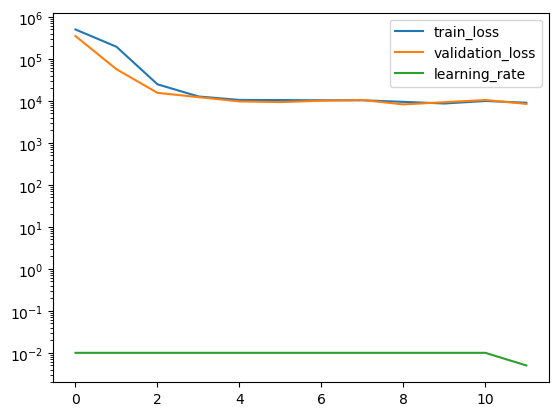

In [7]:
#example cosmosis sklearn regression dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_param = {'in_channels': 256, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'float32',
                            'dataset': 'make_regression',
                            'sk_param': {'n_samples':20000,
                                         'n_features': 256,
                                         'n_informative': 200}}}
             
metrics_param = {'report_interval': 10,
                  'log_plot': True,
                  'min_lr': .005} #break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([SKDS], 
              FFNet,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=MSELoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=256, epochs=40, gpu=True)

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:03.868566
epoch: 0, lr: 0.01
train loss: 0.01069778682930129, val loss: 0.010563025577391824
last 5 targets: 
[2 2 2 0 1]
last 5 predictions: 
[[0.20665033 0.28953913 0.27896103 0.2248495 ]
 [0.19166715 0.20201884 0.404491   0.20182297]
 [0.20545824 0.22441974 0.35750407 0.21261793]
 [0.26642495 0.26934093 0.21129227 0.2529418 ]
 [0.37477684 0.20315951 0.18873276 0.23333088]]
sklearn train metric: 0.5644203234384232, sklearn validation metric: 0.5910933836773519

...........................
learning time: 0:00:34.149190
epoch: 8, lr: 0.01
train loss: 0.008953414514538023, val loss: 0.009140663294710664
last 5 targets: 
[0 3 0 0 3]
last 5 predictions: 
[[0.47437343 0.17503448 0.1752791  0.17531304]
 [0.17487776 0.4753666  0.17487773 0.17487785]
 [0.47373626 0.1751347  0.17594369 0.17518538]
 [0.4126108  0

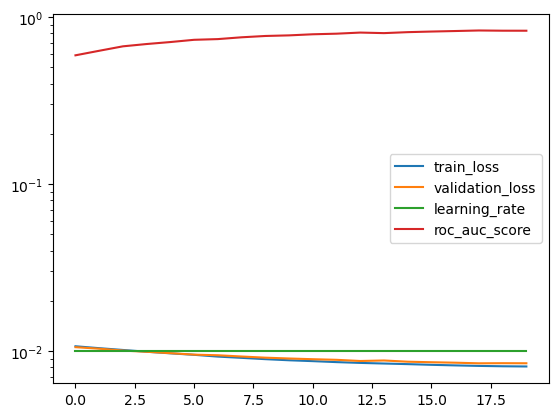

In [8]:
#example cosmosis sklearn classification dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_param = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4,
                'softmax': 'softmax',
                'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'int64',
                            'transforms': {'y': [SqueezeN()],
                                           'X': []},
                            'dataset': 'make_classification',
                            'sk_param': {'n_samples': 100000,
                                         'n_features': 300,
                                         'n_informative': 200,
                                         'n_redundant': 5,
                                         'n_repeated': 5,
                                         'n_clusters_per_class': 5,
                                         'flip_y': 0.05,
                                         'class_sep': 0.05,
                                         'n_classes': 4}}}
                                     
metrics_param = {'report_interval': 30,
                 'log_plot': True,
                 'sk_metric_name': 'roc_auc_score',
                 'sk_param': {'average': 'macro',
                              'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

learm = Learn([SKDS], 
              FFNet, 
              Sampler=Selector,
              Metrics=Metrics,
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, 
              sample_param=sample_param, opt_param=opt_param, 
              sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param,
              adapt=(300,256,.2), 
              squeeze_y_pred=False, batch_size=128, epochs=20, 
              save_model='demo_model')

In [2]:
#example inference with cosmosis sklearn classification dataset wrapper (SKDS) and custom model (FFNet)

model_param = {'in_channels': 256, 
               'hidden': 128, 
               'out_channels': 4, 
               'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['X'],
                                           'y': ['y']},
                            'features_dtype': 'float32',
                            'targets_dtype': 'int64',
                            'dataset': 'make_classification',
                            'sk_param': {'n_samples': 10000,
                                         'n_features': 300,
                                         'n_informative': 200,
                                         'n_clusters_per_class': 3,
                                         'flip_y': 0.05,
                                         'class_sep': 0.1,
                                         'n_classes': 4}}}
                                     
learn = Learn([SKDS], 
              FFNet, 
              Sampler=Selector,
              Metrics=Metrics,
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=None,
              model_param=model_param, ds_param=ds_param, 
              batch_size=128, epochs=1, load_model='demo_model.pth')

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
model loaded from pickle...
running model on gpu...
inference 2024-09-13 08:31:30.788892 complete and saved to csv...


creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
torchvision model resnet18 loaded...
running model on gpu...

...........................
learning time: 0:00:05.323969
epoch: 0, lr: 0.01
train loss: 2.362755599975586, val loss: 2.0637946686437054
last 5 targets: 
[8 9 8 9 9]
last 5 predictions: 
[[0.23105966 0.13540798 0.03348293 0.04065502 0.02843829 0.03056804
  0.04053274 0.13831478 0.16687684 0.15466371]
 [0.12708732 0.13358913 0.06989259 0.10191587 0.05641301 0.08161546
  0.08489241 0.11632373 0.12654792 0.10172249]
 [0.01671539 0.0130542  0.10967401 0.110023   0.23589179 0.13766061
  0.27591792 0.08109304 0.0083286  0.01164153]
 [0.12484904 0.13093448 0.04272137 0.07996803 0.02587766 0.05922902
  0.05669198 0.22491804 0.10912491 0.14568546]
 [0.06002877 0.04892775 0.11226779 0.12652023 0.14510228 0.13472342
  0.18137798 0.10426709 0

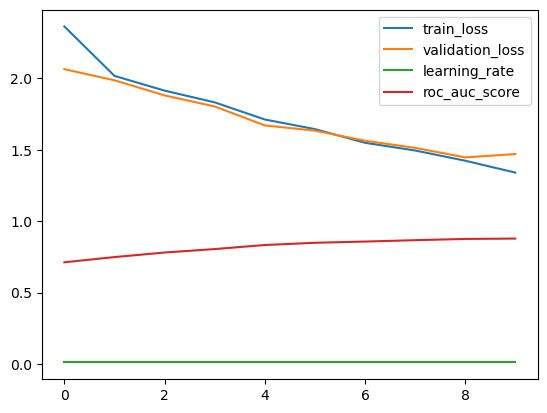

In [10]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_param = {'model_name': 'resnet18',
               'in_channels': 3,
               'tv_param': {'num_classes': 10}}

ds_param={'train_param': {'dataset': 'CIFAR10',
                          'tv_param': {'root': './data/',
                                       'train': True,
                                       'download': True,
                                       'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                       'target_transform': None,
                                       'download': True}},
           'test_param': {'dataset': 'CIFAR10',
                          'tv_param': {'root': './data/',
                                       'train': False,
                                       'download': True,
                                       'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                       'target_transform': None,
                                       'download': True}}}

metrics_param = {'report_interval': 30, 
                 'sk_metric_name': 'roc_auc_score', 
                 'sk_param': {'average': 'macro',
                              'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.8,),
                'subset': .1}

sched_param = {'factor': .5,
               'patience': 1,
               'cooldown': 1}

learn = Learn([TVDS,TVDS], 
              tv_model, 
              Selector, 
              Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
              model_param=model_param, ds_param=ds_param, sample_param=sample_param, 
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=16, epochs=10)

creating torch vision CIFAR10 dataset...
CDataset created...
creating torch vision CIFAR10 dataset...
CDataset created...
torchvision model resnext50_32x4d loaded...
running model on gpu...

...........................
learning time: 0:00:57.103352
epoch: 0, lr: 0.01
train loss: 2.556269061088562, val loss: 2.0992564943528946
last 5 targets: 
[8 9 8 9 9]
last 5 predictions: 
[[0.19075656 0.1293883  0.05550408 0.06677902 0.0393092  0.07080712
  0.02964577 0.0602072  0.21514708 0.14245567]
 [0.11657004 0.13076831 0.07388508 0.09051099 0.06946173 0.09882496
  0.0665718  0.08137517 0.14494897 0.12708297]
 [0.04058054 0.08388852 0.10422997 0.10695907 0.15066254 0.11946031
  0.17069995 0.10850158 0.04864221 0.0663753 ]
 [0.18190823 0.1320362  0.05735463 0.06871139 0.04174187 0.07353328
  0.03169063 0.06198693 0.21178897 0.13924791]
 [0.08693023 0.11912199 0.07740103 0.10770784 0.0793761  0.11426423
  0.09591854 0.10762622 0.1018132  0.10984059]]
sklearn train metric: 0.620851664808747, sklea

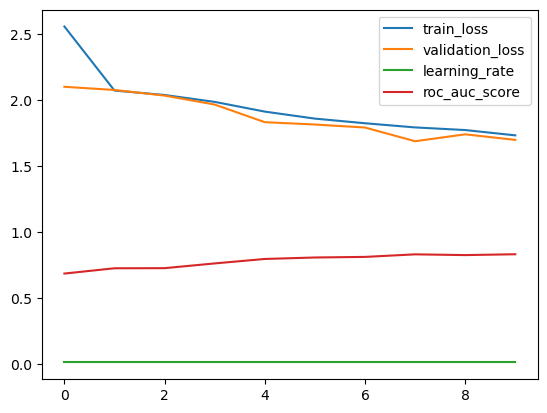

In [13]:
#example cosmosis torchvision dataset wrapper (TVDS) with transforms and 
#torchvision model wrapper (tv_model)
model_param = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_param': {'num_classes': 10}}

ds_param={'train_param': {'dataset': 'CIFAR10',
                            'tv_param': {'root': './data/',
                                         'train': True,
                                         'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                         'target_transform': None}},
           'test_param': {'dataset': 'CIFAR10',
                           'tv_param': {'root': './data/',
                                        'train': False,
                                        'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                        'target_transform': None}}}

metrics_param = {'report_interval': 60, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_param': {'average': 'macro',
                               'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.8,),
                'subset': .1}

sched_param = {'factor': .5,
               'patience': 2,
               'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_param=model_param, ds_param=ds_param, 
          sample_param=sample_param, opt_param=opt_param, 
          sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=16, epochs=10)